# Install & Import Libraries

In [3]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 2.0MB/s 


In [4]:
!pip install keras

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

from PIL import ImageFile,Image
import h5py
#import cv2

#import pydotplus
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


from keras.utils import plot_model
from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras import regularizers # for L2 regularization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

import multiprocessing
from multiprocessing.pool import ThreadPool
import os
from io import BytesIO
from urllib import request
import re

Using TensorFlow backend.


# Authenticate & Mount Google Drive

In [6]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [9]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [10]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print('Files in Drive:')
!ls drive/

# Create a file in Drive.
#!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Files in Drive:
created.txt		  Getting started	Untitled1.ipynb
data_downloader.ipynb	  Landmark_Recognition	Untitled.ipynb
data_explorer-Copy.ipynb  Pandas_Workshop


In [ ]:
!mkdir Landmark_recognition

In [0]:
!mkdir Landmark_recognition/data

# Data Download

In [0]:
lmark_data_200 = pd.read_csv('drive/Landmark_Recognition/lmark_data_200.csv',index_col=0)

In [15]:
lmark_data_200.tail()

,id,url,landmark_id,lmark_id
12218,11fba25fc79e8ff3,http://lh5.ggpht.com/-C1HVMjkA0ss/RsGuVEWLjQI/...,1906,45
12219,188616eab93f7a00,https://lh5.googleusercontent.com/-GXTC6fUR3es...,6231,137
12220,e5432cac7f95d307,http://lh3.ggpht.com/-B5gVjNv7KDI/SLL4i3OxN6I/...,2658,182
12221,3bcbc5f73050d41a,http://lh3.ggpht.com/-y5dC41R72Rc/RdYXo44lAYI/...,7761,113
12222,5b066610bfd570e7,https://lh5.googleusercontent.com/-gLJQiSa6ROI...,12171,124


In [16]:
print(lmark_data_200.nunique())

id             12223
url            12223
landmark_id      200
lmark_id         200
dtype: int64


In [0]:
# set files and dir
DATA_FRAME, OUT_DIR = lmark_data_200, '/content/Landmark_recognition/data'  # recognition challenge
# DATA_FRAME, OUT_DIR = pd.read_csv('../input/index.csv'), '../input/index'  # retrieval challenge
# DATA_FRAME, OUT_DIR = pd.read_csv('../input/test.csv'), '../input/test'  # test data

# preferences
TARGET_SIZE = 128  # image resolution to be stored
IMG_QUALITY = 90  # JPG quality
NUM_WORKERS = 64  # Num of CPUs

In [20]:
DATA_FRAME.url.apply(lambda x: x.split('/')[-2]).value_counts().head()

s1600     10175
rj          971
medium      653
s128        114
s0-d         98
Name: url, dtype: int64

In [0]:
failed_dwnlds=[]

def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)

    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)

    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df


def parse_data(df):
    key_url_list = [line[:2] for line in df.values]
    return key_url_list


def download_image(key_url):
    (key, url) = key_url
    filename = os.path.join(OUT_DIR, '{}.jpg'.format(key))

    if os.path.exists(filename):
        print('Image {} already exists. Skipping download.'.format(filename))
        return 0

    try:
        response = request.urlopen(url)
        image_data = response.read()
    except:
        print('Warning: Could not download image {} from {}'.format(key, url))
        failed_dwnlds.append(key)
        return 1

    try:
        pil_image = Image.open(BytesIO(image_data))
    except:
        print('Warning: Failed to parse image {}'.format(key))
        return 1

    try:
        pil_image_rgb = pil_image.convert('RGB')
    except:
        print('Warning: Failed to convert image {} to RGB'.format(key))
        return 1

    try:
        pil_image_resize = pil_image_rgb.resize((TARGET_SIZE, TARGET_SIZE))
    except:
        print('Warning: Failed to resize image {}'.format(key))
        return 1

    try:
        pil_image_resize.save(filename, format='JPEG', quality=IMG_QUALITY)
    except:
        print('Warning: Failed to save image {}'.format(filename))
        return 1

    return 0


def loader(df):
    if not os.path.exists(OUT_DIR):
        os.mkdir(OUT_DIR)
        
    #pool = multiprocessing.Pool(processes=NUM_WORKERS)
    pool = ThreadPool(processes=NUM_WORKERS)
    key_url_list = parse_data(df)
    
    failures = sum(tqdm(pool.imap_unordered(download_image, key_url_list),
                             total=len(key_url_list)))
    print('Total number of download failures:', failures)
    pool.close()
    pool.terminate()


In [22]:
# now, start downloading
if __name__ == '__main__':
    loader(overwrite_urls(DATA_FRAME))

  3%|▎         | 315/12223 [00:01<00:50, 234.33it/s]

 12%|█▏        | 1430/12223 [00:06<00:46, 231.78it/s]

 14%|█▍        | 1741/12223 [00:07<00:45, 230.79it/s]

 20%|██        | 2465/12223 [00:10<00:42, 232.19it/s]

 21%|██▏       | 2614/12223 [00:11<00:41, 231.93it/s]

 22%|██▏       | 2712/12223 [00:11<00:41, 231.83it/s]

 37%|███▋      | 4505/12223 [00:19<00:33, 227.02it/s]

 39%|███▉      | 4771/12223 [00:21<00:32, 226.08it/s]

 45%|████▍     | 5457/12223 [00:24<00:30, 225.07it/s]

 49%|████▉     | 6042/12223 [00:26<00:27, 224.69it/s]

 55%|█████▌    | 6747/12223 [00:30<00:24, 224.46it/s]

 56%|█████▌    | 6818/12223 [00:30<00:24, 224.25it/s]

 61%|██████    | 7479/12223 [00:33<00:21, 224.15it/s]

 66%|██████▋   | 8100/12223 [00:36<00:18, 223.13it/s]

 67%|██████▋   | 8147/12223 [00:36<00:18, 223.13it/s]

 80%|███████▉  | 9728/12223 [00:43<00:11, 222.15it/s]

 81%|████████  | 9844/12223 [00:44<00:10, 221.98it/s]

 83%|████████▎ | 10113/12223 [00:45<00:09, 221.89it/s]

 87%|████████▋ | 10639/12223 [00:48<00:07, 221.62it/s]

 89%|████████▊ | 10833/12223 [00:48<00:06, 221.53it/s]

 91%|█████████ | 11129/12223 [00:50<00:04, 221.46it/s]

 93%|█████████▎| 11323/12223 [00:51<00:04, 221.38it/s]

 94%|█████████▍| 11464/12223 [00:51<00:03, 221.33it/s]

 99%|█████████▉| 12132/12223 [00:54<00:00, 220.69it/s]

100%|██████████| 12223/12223 [00:56<00:00, 217.27it/s]

Total number of download failures: 25


In [146]:
ls Landmark_recognition/data/|wc -l

ls: cannot access 'Landmark_recognition/data/': No such file or directory
0


In [0]:
for i in failed_dwnlds:
  lmark_data_200 = lmark_data_200.drop(lmark_data_200[lmark_data_200.id == i].index)

In [27]:
lmark_data_200.tail()

,id,url,landmark_id,lmark_id
12193,11fba25fc79e8ff3,http://lh5.ggpht.com/-C1HVMjkA0ss/RsGuVEWLjQI/...,1906,45
12194,188616eab93f7a00,https://lh5.googleusercontent.com/-GXTC6fUR3es...,6231,137
12195,e5432cac7f95d307,http://lh3.ggpht.com/-B5gVjNv7KDI/SLL4i3OxN6I/...,2658,182
12196,3bcbc5f73050d41a,http://lh3.ggpht.com/-y5dC41R72Rc/RdYXo44lAYI/...,7761,113
12197,5b066610bfd570e7,https://lh5.googleusercontent.com/-gLJQiSa6ROI...,12171,124


In [0]:
lmark_data_200=lmark_data_200.reset_index(drop=True)

# Data Preprocessing

In [0]:
filelist =list( lmark_data_200['id']+'.jpg')

In [31]:
cd Landmark_recognition/data

/content/Landmark_recognition/data


In [32]:
images = np.array([np.array(Image.open(fname)) for fname in tqdm(filelist)])


100%|██████████| 12198/12198 [00:08<00:00, 1424.76it/s]

In [0]:
images = images.astype('float32')/255

In [34]:
images.shape

(12198, 128, 128, 3)

In [0]:
landmarks = lmark_data_200['lmark_id'].as_matrix()

In [36]:
landmarks.shape

(12198,)

In [0]:
landmark_class = to_categorical(landmarks,200)

In [38]:
landmark_class.shape

(12198, 200)

# Simple Convolutional Network

In [39]:
x_train, x_test, y_train, y_test = train_test_split(images, landmark_class, 
                                                        test_size = 0.05, 
                                                        random_state = 1)
# Print the shape
print ("Training data shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing data shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training data shape: (11588, 128, 128, 3)
Training target's shape (11588, 200)
Testing data shape: (610, 128, 128, 3)
Testing target's shape (610, 200)


In [0]:
#Objective:Implements & Compiles the AlexNet architecture on given parameters
#inputs:Shape of input image & No. of classes and Optimzer & loss function to be used
#Outputs:Returns the implemented CNN model
#invoked by:N/A
#invokes:N/A
#approach:Uses Keras library functions to implement CNN model

def Simple_CNN_model():
    classifier = Sequential()
    #convolutional layer
    classifier.add(Conv2D(32, (5, 5), strides=2,input_shape = (64, 64, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2),strides=2))
    Dropout(0.25)
   
    classifier.add(Conv2D(64, (5, 5),padding='same',activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2),strides=2))
    Dropout(0.25)
 
    #Flattening
    classifier.add(Flatten())
    #Full connection
    classifier.add(Dense(units = 800, activation = 'tanh'))
    Dropout(0.25)
    classifier.add(Dense(units = 500, activation = 'tanh'))
    classifier.add(Dense(units = 200, activation = 'softmax'))
    # Compiling the CNN
    classifier.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

In [0]:
def Simple_CNN_model2():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same',input_shape=(128, 128, 3)))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('tanh'))
  model.add(Dropout(0.5))
  model.add(Dense(1024))
  model.add(Activation('tanh'))
  model.add(Dropout(0.5))
  model.add(Dense(1024))
  model.add(Activation('tanh'))
  model.add(Dropout(0.5))
  model.add(Dense(200))
  model.add(Activation('softmax'))
  
  model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  
  return model

In [0]:
model=Simple_CNN_model2()

In [109]:
model.fit(x_train, y_train,epochs=30, batch_size=16, verbose=1)

Epoch 1/30
5819/5819 [==============================] - 4s 730us/step - loss: 71.5561 - acc: 0.0588
Epoch 2/30
5819/5819 [==============================] - 4s 649us/step - loss: 36.5852 - acc: 0.0902
Epoch 3/30
5819/5819 [==============================] - 4s 643us/step - loss: 19.6162 - acc: 0.1401
Epoch 4/30
5819/5819 [==============================] - 4s 639us/step - loss: 11.3572 - acc: 0.1698
Epoch 5/30
5520/5819 [===========================>..] - ETA: 0s - loss: 7.4426 - acc: 0.18415819/5819 [==============================] - 4s 645us/step - loss: 7.3864 - acc: 0.1832
Epoch 6/30
5819/5819 [==============================] - 4s 636us/step - loss: 5.4438 - acc: 0.1949
Epoch 7/30
5819/5819 [==============================] - 4s 620us/step - loss: 4.4785 - acc: 0.2091
Epoch 8/30
5819/5819 [==============================] - 4s 628us/step - loss: 3.9811 - acc: 0.2188
Epoch 9/30
5819/5819 [==============================] - 4s 622us/step - loss: 3.7187 - acc: 0.2311
Epoch 10/30
1600/5819 [=

# Data Augmentation

In [40]:
  datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)
  print(type(datagen.fit(x_train)))

<class 'NoneType'>


In [73]:
    # Fit the model on the batches generated by datagen.flow().
  model.fit_generator(datagen.flow(x_train, y_train,batch_size=32),epochs=80,workers=4)

Epoch 1/80
182/182 [==============================] - 28s 153ms/step - loss: 1.3746 - acc: 0.6240
Epoch 2/80
182/182 [==============================] - 28s 152ms/step - loss: 1.3596 - acc: 0.6300
Epoch 3/80
170/182 [===========================>..] - ETA: 1s - loss: 1.3468 - acc: 0.6292182/182 [==============================] - 28s 152ms/step - loss: 1.3538 - acc: 0.6277
Epoch 4/80
182/182 [==============================] - 28s 153ms/step - loss: 1.3154 - acc: 0.6436
Epoch 5/80
182/182 [==============================] - 27s 151ms/step - loss: 1.2895 - acc: 0.6447
Epoch 6/80
 42/182 [=====>........................] - ETA: 22s - loss: 1.2569 - acc: 0.6577182/182 [==============================] - 28s 152ms/step - loss: 1.2939 - acc: 0.6454
Epoch 7/80
182/182 [==============================] - 28s 153ms/step - loss: 1.2415 - acc: 0.6557
Epoch 8/80
182/182 [==============================] - 28s 152ms/step - loss: 1.2674 - acc: 0.6577
Epoch 9/80
 15/182 [=>............................] - ETA

In [74]:
preds=model.evaluate(x_test,y_test)

307/307 [==============================] - 1s 2ms/step


In [75]:
preds[0]

1.654766565813692

In [76]:
preds[1]*100

71.33550506073023

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 31, 31, 64)        18496     
__________

# Calculate Recall

In [0]:
yt=np.argmax(y_test,axis=1)

In [108]:
yt

array([ 65, 112,  61, 100,   0,  61,  17, 118,  85, 193, 159, 112,  39,
        37,  76, 104,  11,  61, 197,  63,  27, 164, 141, 125,  61,   5,
         2,  23,  34, 164,  99, 145, 166,  80,  37, 193, 132,  57,  92,
        12,  49, 141, 100, 136,  44,   0,  92,  19,  61, 184,  82, 105,
       177, 123,  92,  30,  45, 127, 134, 153, 134,  13,  81, 153, 140,
        49, 129, 132,  60,  18,   0, 188,  99,   2,  37,  50,   1,  99,
         6, 193,  61,  64, 184,  61, 196,  97,  49, 146, 199,   8, 155,
        90, 193,  45,  51, 193,  57,   1, 150,  99,  95, 116,  35, 180,
         0,  22,  75,  27, 103,  85, 106, 196, 164, 193, 111,  81, 109,
       184, 192,  49,  27, 155, 138, 180,   0,  83, 111,  49, 154, 105,
        64, 106,  75, 172, 194, 196,  91, 100,   0,  72,  46, 158,  36,
       142,  35,  55, 104, 188,   2, 124,  84,  68,  35,  93,  24,   6,
        89,  96, 151,  37,  61,  14, 159, 193,  95, 124,  97, 100,  67,
       196,  34,  29, 191, 153,   1, 152, 155,  92,  85,  48, 14

In [0]:
unq,cnt=np.unique(yt,return_counts=True)

In [0]:
recall=dict(zip(unq,np.zeros(len(unq))))

In [0]:
for i in range(len(yt)):
  if predictions[i]==yt[i]:
    recall[yt[i]]+=1
  

In [0]:
recall2=dict(zip(unq,cnt))

In [0]:
recall3=np.zeros([len(unq),3])

In [0]:
for i in range(len(unq)):
  recall3[i][0]=recall[unq[i]]
  recall3[i][1]=recall2[unq[i]]
  recall3[i][2]=recall[unq[i]]/recall2[unq[i]]

In [0]:
recall_values=dict(zip(unq,recall3))

In [137]:
%precision 2

'%.2f'

In [138]:
recall_values

{0: array([11.  , 12.  ,  0.92]),
 1: array([6.  , 7.  , 0.86]),
 2: array([2.  , 7.  , 0.29]),
 3: array([2., 2., 1.]),
 4: array([0., 1., 0.]),
 5: array([1. , 2. , 0.5]),
 6: array([7., 7., 1.]),
 8: array([3.  , 4.  , 0.75]),
 13: array([5.  , 6.  , 0.83]),
 15: array([1., 1., 1.]),
 16: array([2., 2., 1.]),
 17: array([3. , 5. , 0.6]),
 18: array([1., 1., 1.]),
 19: array([2. , 4. , 0.5]),
 20: array([1. , 2. , 0.5]),
 21: array([2.  , 3.  , 0.67]),
 23: array([3.  , 7.  , 0.43]),
 24: array([1. , 2. , 0.5]),
 25: array([0., 2., 0.]),
 26: array([0., 1., 0.]),
 27: array([4. , 5. , 0.8]),
 29: array([1., 1., 1.]),
 30: array([3., 3., 1.]),
 31: array([2.  , 3.  , 0.67]),
 32: array([1. , 2. , 0.5]),
 34: array([5.  , 7.  , 0.71]),
 35: array([3. , 6. , 0.5]),
 36: array([4., 4., 1.]),
 37: array([4.  , 6.  , 0.67]),
 38: array([4., 4., 1.]),
 39: array([ 8. , 10. ,  0.8]),
 42: array([1., 1., 1.]),
 44: array([1., 1., 1.]),
 45: array([0., 1., 0.]),
 47: array([0., 1., 0.]),
 48: 

# Transfer Learning (200 classes model)

In [0]:
from keras.applications import VGG19
from keras import optimizers

In [0]:
vgg_model = VGG19(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))

In [43]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
for layer in vgg_model.layers[:4]:
  layer.trainable = False

In [0]:
x = vgg_model.output
x = Flatten()(x)
x = Dense(1024, activation="tanh")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="tanh")(x)
predictions = Dense(200, activation="softmax")(x)

In [59]:
vgg_model_final = Model(input =vgg_model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [0]:
vgg_model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [61]:
history=vgg_model_final.fit_generator(datagen.flow(x_train, y_train,batch_size=32),epochs=50,workers=4)

Epoch 1/50
363/363 [==============================] - 108s 297ms/step - loss: 5.0942 - acc: 0.0286
Epoch 2/50
349/363 [===========================>..] - ETA: 4s - loss: 4.5910 - acc: 0.0977363/363 [==============================] - 107s 294ms/step - loss: 4.5882 - acc: 0.0975
Epoch 3/50
363/363 [==============================] - 107s 294ms/step - loss: 4.0585 - acc: 0.1893
Epoch 4/50
119/363 [========>.....................] - ETA: 1:11 - loss: 3.7575 - acc: 0.2353363/363 [==============================] - 107s 294ms/step - loss: 3.6221 - acc: 0.2661
Epoch 5/50
363/363 [==============================] - 107s 294ms/step - loss: 3.2647 - acc: 0.3315
Epoch 6/50
 53/363 [===>..........................] - ETA: 1:32 - loss: 3.0095 - acc: 0.3939363/363 [==============================] - 107s 294ms/step - loss: 2.9554 - acc: 0.3951
Epoch 7/50
363/363 [==============================] - 107s 294ms/step - loss: 2.6710 - acc: 0.4509
Epoch 8/50
 34/363 [=>............................] - ETA: 1:38 - 

In [62]:
preds=vgg_model_final.evaluate(x_test,y_test)

610/610 [==============================] - 2s 4ms/step


In [63]:
preds[0]

0.5291968886969519

In [64]:
preds[1]*100

85.24590163934425

In [83]:
vgg_model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

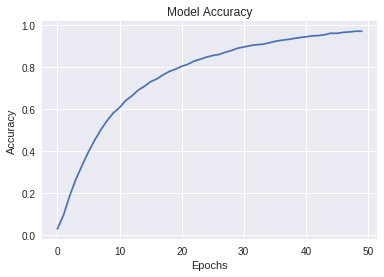

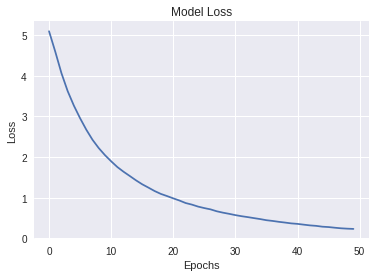

In [151]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.figure(figsize=(100,200))
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Predicting labels for Test Set

In [0]:
y_proba = vgg_model_final.predict(x_test)
y_classes = y_proba.argmax(axis=-1)

In [102]:
y_classes

array([ 65, 112,  61, 100,   0,  61,  17, 118,  85, 193, 159, 137,  39,
        37,  76, 100,  11,  61, 197,  63,  27, 164, 141, 172,  61, 131,
         2,  23,  34, 164,  99, 145, 166, 106,  37, 193, 132,  57,  92,
        12,  49, 141, 100, 188,  44,   0,  92,  19,  61, 184,  82, 105,
       177, 123,  92,  77,  45, 107, 134, 153, 174,  13,  81, 153, 140,
        49, 129, 132,  60, 196, 105, 188,  99,   2,  37,  50,   1,  99,
         6, 193,  41,  64, 184,  61, 196,  97,  49, 146, 199,   8, 155,
        90, 193,  45,  51, 193, 119,   1, 150,  99,  95,   5,  35, 180,
         0, 106,  75,  27, 103,  85, 106, 196, 164, 193, 111,  81, 109,
       184,  39,  49,  27, 155, 138, 180,   0,  83, 111,  49, 154, 105,
        64, 106,  75, 172,   1, 196, 177, 100,   0,  72,  46, 158,  36,
       142,  99,  92, 104, 188,   2, 124,  84,  68,  35, 108,  24,   6,
       177,  96, 151,  37,  61,  14, 159, 193,  95, 124,  97,  45,  67,
       196,  33,  29, 191, 153, 161, 152, 155,  92,  85,  48, 14

   Actual Class: 5
   Predicted Class: 131


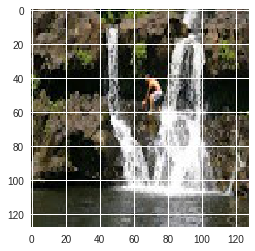

In [145]:
i=25
print("   Actual Class:",yt[i])
print("   Predicted Class:",y_classes[i])
plt.imshow(x_test[i])
plt.show()